## Merging injury and gamelog data

In [4]:
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder

/Users/freedom/anaconda3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# File I/O

In [5]:
injury_file = 'injuries.csv'
injury = pd.read_csv(injury_file)

game_file = 'gamelogs.csv'
games = pd.read_csv(game_file, index_col=0)

In [7]:
9043 - 6396

2647

In [6]:
print(injury.shape)
injury.head()


(9043, 4)


,Date,DL_length,player_id,dt_date
0,20000323,60,thomj005,2000-03-23
1,20000401,15,alvaw001,2000-04-01
2,20000401,15,osuna002,2000-04-01
3,20000408,15,hamid001,2000-04-08
4,20000408,15,timlm001,2000-04-08


In [19]:
games.head()

,real_index,date,num_game,day,v_team,v_team_game_num,h_team,h_team_game_num,v_team_score,h_team_score,...,h_pl_1_id,h_pl_2_id,h_pl_3_id,h_pl_4_id,h_pl_5_id,h_pl_6_id,h_pl_7_id,h_pl_8_id,h_pl_9_id,intra_league
dt_date,,,,,,,,,,,,,,,,,,,,,
2000-03-29,0,20000329,0,Wed,CHN,1,NYN,1,5,3,...,hendr001,hamid001,alfoe001,piazm001,ventr001,belld001,zeilt001,ordor001,hampm001,1
2000-03-30,1,20000330,0,Thu,NYN,2,CHN,2,5,1,...,youne001,bufod001,sosas001,gracm001,rodrh001,andrs001,husoj001,giraj001,farnk001,1
2000-04-03,2,20000403,0,Mon,KCA,1,TOR,1,4,5,...,stews002,bushh001,mondr002,delgc001,fullb001,batit001,fletd001,cruzj004,gonza001,1
2000-04-03,3,20000403,0,Mon,CHA,1,TEX,1,4,10,...,clayr001,greer001,rodri001,palmr001,mater001,segud001,kaplg001,evant001,alicl001,1
2000-04-03,4,20000403,0,Mon,DET,1,OAK,1,7,4,...,beckr002,tejam001,giamj001,jahaj001,staim001,grieb001,hernr002,chave001,menef001,1


In [ ]:
# How big is this games table?
print(games.shape)
#(41292, 96)

## Creating a Target column:
When I loop through the game log table, I am going to update a column for "injury" at any game where we know a player on the disabled list played in THAT game and went on the DL soon after.

In [23]:
# Create a column of zeros for 'injury' TARGET column to append to the games df that matches
# the games row length: 43720 rows long
games['injury']  = np.zeros((games.shape[0],), dtype=np.int)

(41292, 96)


In [20]:
games.head(2)

,real_index,date,num_game,day,v_team,v_team_game_num,h_team,h_team_game_num,v_team_score,h_team_score,...,h_pl_1_id,h_pl_2_id,h_pl_3_id,h_pl_4_id,h_pl_5_id,h_pl_6_id,h_pl_7_id,h_pl_8_id,h_pl_9_id,intra_league
dt_date,,,,,,,,,,,,,,,,,,,,,
2000-03-29,0,20000329,0,Wed,CHN,1,NYN,1,5,3,...,hendr001,hamid001,alfoe001,piazm001,ventr001,belld001,zeilt001,ordor001,hampm001,1
2000-03-30,1,20000330,0,Thu,NYN,2,CHN,2,5,1,...,youne001,bufod001,sosas001,gracm001,rodrh001,andrs001,husoj001,giraj001,farnk001,1


### For the sake of using the function, subset games to just columns needed for finding DL list players: pl_id cols: real_index col and cols 71:95

In [24]:
# Create a small subset of the indexed games dataframe to only include the game date 
# and all the players' ids, cols 71:95
sm_games = pd.concat([games.iloc[:,0], games.iloc[:,71:95]], axis=1)
sm_games.shape

(41292, 25)

### Create a dictionary with real_index as the key and 0 as the values, to update += 1 every time a game row was the last game a DL player played in before his Disabled List placement date:

In [25]:
# This creates (and clears) the injury_update dictionary that will become the TARGET column:
injury_update_dict = games['injury']
injury_update_dict = injury_update_dict.reset_index()
injury_update_dict = injury_update_dict.drop('dt_date',axis=1).to_dict()
sum(injury_update_dict['injury'].values())

0

## Update injury_update_dict:
* Loop through all rows in the Disabled List data, and for every placement (dl_place), 
  * subset the games data to all games 10 days before that DL placement date to save search time. 
  * Loop through all games in the subset, and 
      * if the player_id from the placement is in the game, 
          * save that row index as the index to update. 
          
  * Increase the value of the injury_update_dict whose key is the index to update by + 1
 

### TESTING A LOOP ON SUBSET BEFORE DEFINING A FUNCTION:

In [402]:
# FOR PRACTICE RUNS THROUGH THE FOR LOOPS:
# Subset dataframes to practice on:
sm_games_subset = sm_games.iloc[:5000,:].copy()
sm_inj_subset = injury.iloc[:150,2:].copy()

injury_count = 0
for dl_place in sm_inj_subset.itertuples():
    print(dl_place)
    if dl_place[1] is not np.nan:
        pid = dl_place[1]
        search_end_day = dl_place[2]
        search_start_day = search_end_day-pd.offsets.Day(10)
        subset_games = sm_games_subset[search_start_day:search_end_day]
        for game in subset_games.itertuples():
            if pid in game:
                print('yes')
                print(game.real_index)
                game_index_to_update = game.real_index 
        injury_update_dict['injury'][game_index_to_update] += 1
        injury_count += 1

# Check how many injuries recorded        
print('injury count:', injury_count, 'dict count:',sum(injury_update_dict['injury'].values()))


Pandas(Index=0, player_id='thomj005', dt_date=Timestamp('2000-03-23 00:00:00'))
Pandas(Index=1, player_id='alvaw001', dt_date=Timestamp('2000-04-01 00:00:00'))
Pandas(Index=2, player_id='osuna002', dt_date=Timestamp('2000-04-01 00:00:00'))
Pandas(Index=3, player_id='hamid001', dt_date=Timestamp('2000-04-08 00:00:00'))
yes
0
yes
1
yes
30
yes
44
Pandas(Index=4, player_id='timlm001', dt_date=Timestamp('2000-04-08 00:00:00'))
Pandas(Index=5, player_id='hernc001', dt_date=Timestamp('2000-04-08 00:00:00'))
yes
5
yes
30
yes
44
Pandas(Index=6, player_id='wagnb001', dt_date=Timestamp('2000-06-21 00:00:00'))
yes
951
Pandas(Index=7, player_id='olivd001', dt_date=Timestamp('2000-06-21 00:00:00'))
yes
899
yes
971
Pandas(Index=8, player_id='cabra001', dt_date=Timestamp('2000-07-03 00:00:00'))
yes
1106
yes
1121
yes
1150
yes
1165
Pandas(Index=9, player_id=nan, dt_date=Timestamp('2000-07-07 00:00:00'))
Pandas(Index=10, player_id='ferno001', dt_date=Timestamp('2000-07-07 00:00:00'))
yes
1165
yes
1243
Pa

Pandas(Index=111, player_id=nan, dt_date=Timestamp('2001-04-21 00:00:00'))
Pandas(Index=112, player_id='osuna002', dt_date=Timestamp('2001-04-21 00:00:00'))
Pandas(Index=113, player_id='hillg001', dt_date=Timestamp('2001-04-22 00:00:00'))
yes
2554
yes
2564
yes
2594
yes
2608
yes
2631
yes
2649
yes
2660
Pandas(Index=114, player_id=nan, dt_date=Timestamp('2001-04-22 00:00:00'))
Pandas(Index=115, player_id=nan, dt_date=Timestamp('2001-04-24 00:00:00'))
Pandas(Index=116, player_id='walkk001', dt_date=Timestamp('2001-04-24 00:00:00'))
Pandas(Index=117, player_id=nan, dt_date=Timestamp('2001-04-25 00:00:00'))
Pandas(Index=118, player_id='stepg001', dt_date=Timestamp('2001-04-25 00:00:00'))
Pandas(Index=119, player_id='alvaw001', dt_date=Timestamp('2001-04-25 00:00:00'))
Pandas(Index=120, player_id='wittb001', dt_date=Timestamp('2001-04-25 00:00:00'))
Pandas(Index=121, player_id='leita001', dt_date=Timestamp('2001-04-25 00:00:00'))
yes
2664
Pandas(Index=122, player_id='cresf001', dt_date=Timest

# DEFINE A FUNCTION TO FIND THE LAST GAME PLAYED:
* Make sure to clear out the injury_update_dict between iterations

In [19]:
def find_last_game(player_id, dl_date, games_df, num_days):
    """Function takes in a player_id and disabled list placement
    date and subsets the game logs (with a datetime index) to find the last date they played before
    the disabled list placement"""
    game_index_to_update = 999999
    search_end_day = dl_date
    search_start_day = search_end_day - pd.offsets.Day(num_days)
    subset_games = games_df[search_start_day:search_end_day]
    if subset_games.shape[0] > 0: # IF there are games 20 days before that day
        for game in subset_games.itertuples(): #loop through all games in 20 day period
            if player_id in game:
                game_index_to_update = game.real_index
            else:
                continue
    else: # If there were no games to check, return out of the function
        return game_index_to_update
    return game_index_to_update

## Use `find_last_game()` to create TARGET column:

In [517]:
# Use sm_games
sm_inj = injury.iloc[:,2:].copy()

injury_count = 0
for dl_place in sm_inj.itertuples():
    if dl_place[1] is not np.nan:
        index_to_update = find_last_game(dl_place[1],dl_place[2],sm_games,200)
        if index_to_update != 999999:
            injury_update_dict['injury'][index_to_update] += 1
            injury_count += 1
        else:
            continue
# Check how many injuries recorded        
print('injury count:', injury_count, 'dict count:',sum(injury_update_dict['injury'].values()))

injury count: 6396 dict count: 6396


### Add the values from the injury update dict back into the games

In [522]:
games['injury'] = games['real_index'].map(injury_update_dict['injury'])

In [524]:
games['injury'].value_counts()

0    36399
1     3611
2     1101
3      149
4       25
5        6
6        1
Name: injury, dtype: int64

In [526]:
games_prep = games.copy()

### One Hot Encode Categorical Columns before saving to CSV

In [527]:
games_prep.columns

Index(['real_index', 'date', 'num_game', 'day', 'v_team', 'v_team_game_num',
       'h_team', 'h_team_game_num', 'v_team_score', 'h_team_score',
       'game_length_outs', 'day_night', 'park_id', 'attendance',
       'time_game_min', 'v_at_bats', 'v_hits', 'v_doubles', 'v_triples',
       'v_homeruns', 'v_RBI', 'v_sac_hits', 'v_sac_files', 'v_hit_pitch',
       'v_walks', 'v_int_walks', 'v_strikeouts', 'v_stol_base',
       'v_caught_steal', 'v_grnd_dbl_plays', 'v_awd_fst_catch_intf',
       'v_left_on_base', 'v_pitchers', 'v_ind_earn_runs', 'v_team_earn_runs',
       'v_wild_pitch', 'v_balks', 'v_putouts', 'v_assists', 'v_errors',
       'v_pass_balls', 'v_dbl_plays', 'v_trp_plays', 'h_at_bats', 'h_hits',
       'h_doubles', 'h_triples', 'h_homeruns', 'h_RBI', 'h_sac_hits',
       'h_sac_files', 'h_hit_pitch', 'h_walks', 'h_int_walks', 'h_strikeouts',
       'h_stol_base', 'h_caught_steal', 'h_grnd_dbl_plays',
       'h_awd_fst_catch_intf', 'h_left_on_base', 'h_pitchers',
       'h_in

In [528]:
col = ['day', 'v_team', 'h_team', 'day_night', 'park_id']
games_w_dummies = pd.get_dummies(games_prep,columns=col, drop_first=True)

In [530]:
print(games_w_dummies.columns)
print(games_w_dummies.shape)

Index(['real_index', 'date', 'num_game', 'v_team_game_num', 'h_team_game_num',
       'v_team_score', 'h_team_score', 'game_length_outs', 'attendance',
       'time_game_min',
       ...
       'park_id_SFO03', 'park_id_SJU01', 'park_id_STL09', 'park_id_STL10',
       'park_id_STP01', 'park_id_SYD01', 'park_id_TOK01', 'park_id_TOR02',
       'park_id_WAS10', 'park_id_WAS11'],
      dtype='object', length=207)
(41292, 207)


## Save Full DataFrame to CSV for Further Investigation

In [531]:
games_w_dummies.to_csv("games_w_inj_dums.csv")

## Drop the 'real_index' and player id cols for the model:

In [537]:
cols_to_drop = [col for col in games_w_dummies.columns if ('id' in col) and ('park' not in col)]
cols_to_drop.append('real_index')
cols_to_keep = [item for item in games_w_dummies.columns if item not in cols_to_drop]
cols_to_keep

['date',
 'num_game',
 'v_team_game_num',
 'h_team_game_num',
 'v_team_score',
 'h_team_score',
 'game_length_outs',
 'attendance',
 'time_game_min',
 'v_at_bats',
 'v_hits',
 'v_doubles',
 'v_triples',
 'v_homeruns',
 'v_RBI',
 'v_sac_hits',
 'v_sac_files',
 'v_hit_pitch',
 'v_walks',
 'v_int_walks',
 'v_strikeouts',
 'v_stol_base',
 'v_caught_steal',
 'v_grnd_dbl_plays',
 'v_awd_fst_catch_intf',
 'v_left_on_base',
 'v_pitchers',
 'v_ind_earn_runs',
 'v_team_earn_runs',
 'v_wild_pitch',
 'v_balks',
 'v_putouts',
 'v_assists',
 'v_errors',
 'v_pass_balls',
 'v_dbl_plays',
 'v_trp_plays',
 'h_at_bats',
 'h_hits',
 'h_doubles',
 'h_triples',
 'h_homeruns',
 'h_RBI',
 'h_sac_hits',
 'h_sac_files',
 'h_hit_pitch',
 'h_walks',
 'h_int_walks',
 'h_strikeouts',
 'h_stol_base',
 'h_caught_steal',
 'h_grnd_dbl_plays',
 'h_awd_fst_catch_intf',
 'h_left_on_base',
 'h_pitchers',
 'h_ind_earn_runs',
 'h_team_earn_runs',
 'h_wild_pitch',
 'h_balks',
 'h_putouts',
 'h_assists',
 'h_errors',
 'h_pass_

In [555]:
games_X = games_w_dummies.loc[:,cols_to_keep]

In [556]:
games_X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41292 entries, 2000-03-29 to 2016-10-02
Columns: 182 entries, date to park_id_WAS11
dtypes: float64(1), int64(66), uint8(115)
memory usage: 26.0 MB


## Save the X DataFrame to CSV for Modeling

In [557]:
games_X.to_csv('games_features_for_model.csv')

## Bring back the dataframe that had player IDs to add more player data in for further reserach (next steps):

In [9]:
# When you don't want to re-run all the File I/O again but want to do EDA:
games_w_dummies = pd.read_csv("games_w_inj_dums.csv")

In [10]:
games_w_dummies.head()

,dt_date,real_index,date,num_game,v_team_game_num,h_team_game_num,v_team_score,h_team_score,game_length_outs,attendance,...,park_id_SFO03,park_id_SJU01,park_id_STL09,park_id_STL10,park_id_STP01,park_id_SYD01,park_id_TOK01,park_id_TOR02,park_id_WAS10,park_id_WAS11
0,2000-03-29,0,20000329,0,1,1,5,3,54,55000.0,...,0,0,0,0,0,0,1,0,0,0
1,2000-03-30,1,20000330,0,2,2,5,1,66,55000.0,...,0,0,0,0,0,0,1,0,0,0
2,2000-04-03,2,20000403,0,3,1,1,7,51,48156.0,...,0,0,1,0,0,0,0,0,0,0
3,2000-04-03,3,20000403,0,1,1,0,2,51,42255.0,...,0,0,0,0,0,0,0,0,0,0
4,2000-04-03,4,20000403,0,1,1,4,6,51,35101.0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
games_w_dummies['dt_date'] = pd.to_datetime(games_w_dummies['dt_date'])

In [ ]:
plt.figure(figsize=(15,5))
sns.('dt_date','injury', data=games_w_dummies)

/Users/freedom/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


In [18]:
games_w_dummies.iloc[:,67:86].head()

,v_mgr_id,h_mgr_id,w_pitch_id,l_pitch_id,v_start_pitch_id,h_start_pitch_id,v_pl_1_id,v_pl_2_id,v_pl_3_id,v_pl_4_id,v_pl_5_id,v_pl_6_id,v_pl_7_id,v_pl_8_id,v_pl_9_id,h_pl_1_id,h_pl_2_id,h_pl_3_id,h_pl_4_id
0,bayld001,valeb102,liebj001,hampm001,liebj001,hampm001,youne001,bufod001,gracm001,sosas001,rodrh001,andrs001,nievj002,giraj001,liebj001,hendr001,hamid001,alfoe001,piazm001
1,valeb102,bayld001,cookd001,yound002,reedr002,farnk001,hendr001,hamid001,alfoe001,piazm001,ventr001,belld001,zeilt001,ordor001,reedr002,youne001,bufod001,sosas001,gracm001
2,bayld001,larut101,kiled001,tapak001,tapak001,kiled001,youne001,gutir001,sosas001,gracm001,rodrh001,andrs001,bufod001,giraj001,tapak001,vinaf001,rente001,lankr001,tatif001
3,bellb001,cox-b103,maddg002,astap001,astap001,maddg002,goodt001,lansm001,walkl001,cirij001,heltt001,hammj001,peren001,maynb001,astap001,veraq001,sandr002,jonec004,jordb001
4,baked002,bolej801,ferna001,hernl003,hernl003,ferna001,benam001,muelb001,bondb001,kentj001,snowj001,burke001,aurir001,estab001,hernl003,castl001,gonza002,floyc001,wilsp002


In [ ]:
search_games_df = games_w_dummies.set_index('dt_date')


In [22]:
search_games_df.head()

,real_index,date,num_game,v_team_game_num,h_team_game_num,v_team_score,h_team_score,game_length_outs,attendance,time_game_min,...,park_id_SFO03,park_id_SJU01,park_id_STL09,park_id_STL10,park_id_STP01,park_id_SYD01,park_id_TOK01,park_id_TOR02,park_id_WAS10,park_id_WAS11
dt_date,,,,,,,,,,,,,,,,,,,,,
2000-03-29,0,20000329,0,1,1,5,3,54,55000.0,206,...,0,0,0,0,0,0,1,0,0,0
2000-03-30,1,20000330,0,2,2,5,1,66,55000.0,235,...,0,0,0,0,0,0,1,0,0,0
2000-04-03,2,20000403,0,3,1,1,7,51,48156.0,174,...,0,0,1,0,0,0,0,0,0,0
2000-04-03,3,20000403,0,1,1,0,2,51,42255.0,134,...,0,0,0,0,0,0,0,0,0,0
2000-04-03,4,20000403,0,1,1,4,6,51,35101.0,166,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Find hamid001's last game:
dl_date = pd.to_datetime('2000-04-08')
game_of_interest = find_last_game('hamid001', 
                                  dl_date, search_games_df, 15)
search_games_df.iloc[game_of_interest,67:86]

h_mgr_id            valeb102
w_pitch_id          clemm001
l_pitch_id          hampm001
v_start_pitch_id    clemm001
h_start_pitch_id    hampm001
v_pl_1_id           marta001
v_pl_2_id           jackd003
v_pl_3_id           river002
v_pl_4_id           nevip001
v_pl_5_id           owene001
v_pl_6_id           boonb002
v_pl_7_id           sprae001
v_pl_8_id           hernc001
v_pl_9_id           clemm001
h_pl_1_id           hendr001
h_pl_2_id           hamid001
h_pl_3_id           alfoe001
h_pl_4_id           piazm001
h_pl_5_id           ventr001
Name: 2000-04-06 00:00:00, dtype: object

In [28]:

search_games_df.iloc[44,67:86]

h_mgr_id            valeb102
w_pitch_id          clemm001
l_pitch_id          hampm001
v_start_pitch_id    clemm001
h_start_pitch_id    hampm001
v_pl_1_id           marta001
v_pl_2_id           jackd003
v_pl_3_id           river002
v_pl_4_id           nevip001
v_pl_5_id           owene001
v_pl_6_id           boonb002
v_pl_7_id           sprae001
v_pl_8_id           hernc001
v_pl_9_id           clemm001
h_pl_1_id           hendr001
h_pl_2_id           hamid001
h_pl_3_id           alfoe001
h_pl_4_id           piazm001
h_pl_5_id           ventr001
Name: 2000-04-06 00:00:00, dtype: object

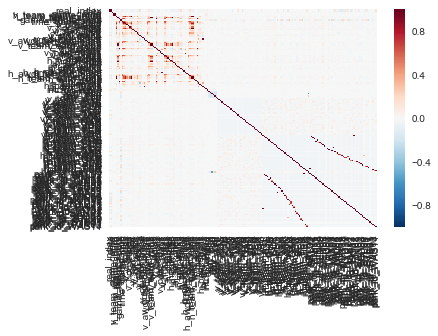

In [38]:
sns.heatmap(games_w_dummies.corr())